In [21]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [22]:
base_path = "C:/BeCode/customerRevanalysisDS/"

In [50]:
df1= pd.read_csv(base_path + "1429_1.csv")
df2= pd.read_csv(base_path + "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
df3= pd.read_csv(base_path + "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")

C:\Users\genet\AppData\Local\Temp\ipykernel_6664\744756155.py:1: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df1= pd.read_csv(base_path + "1429_1.csv")


Cleaning the data

In [24]:
df1.columns

Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username'],
      dtype='object')

Drop uneccesary columns from the data frames

In [51]:
cols_tokeep = ['name', 'brand', 'asins', 'categories', 'reviews.text', 'reviews.rating', 'reviews.date', 'reviews.doRecommend']
df1= df1[cols_tokeep]
df1.columns

Index(['name', 'brand', 'asins', 'categories', 'reviews.text',
       'reviews.rating', 'reviews.date', 'reviews.doRecommend'],
      dtype='object')

In [26]:
df2= df2[cols_tokeep]
df2.columns

Index(['name', 'brand', 'categories', 'reviews.text', 'reviews.rating',
       'reviews.date', 'reviews.doRecommend'],
      dtype='object')

In [27]:
df3= df3[cols_tokeep]
df3.columns

Index(['name', 'brand', 'categories', 'reviews.text', 'reviews.rating',
       'reviews.date', 'reviews.doRecommend'],
      dtype='object')

In [28]:
print(str(df1.shape[0]) + ",   "  + str(df2.shape[0]) + ",   " + str(df3.shape[0]))
print("total rows: " + str(df1.shape[0]+ df2.shape[0] + df3.shape[0]))

34660,   5000,   28332
total rows: 67992


In [52]:
# df= pd.concat([df1, df2, df3], axis=0)
df = df1
print(df.shape)

(34660, 8)


In [53]:
df.isna().sum()

name                   6760
brand                     0
asins                     2
categories                0
reviews.text              1
reviews.rating           33
reviews.date             39
reviews.doRecommend     594
dtype: int64

Remove all rows with nan value in column name because that is the main column we need to get its review
Subsecuently remove othe rows with null values becase they are small in number.

In [54]:
#remove records where name is missing
df=df[df['name'].notna()]
df.isna().sum()

name                     0
brand                    0
asins                    2
categories               0
reviews.text             1
reviews.rating          32
reviews.date            27
reviews.doRecommend    491
dtype: int64

In [55]:
#remove records where ratings are missing, they are small number and wont affect
df=df[df['reviews.rating'].notna()]
df.isna().sum()

name                     0
brand                    0
asins                    2
categories               0
reviews.text             1
reviews.rating           0
reviews.date            18
reviews.doRecommend    459
dtype: int64

In [58]:
#remove records where date are missing, they are small number and wont affect
df=df.dropna()
df.isna().sum()

name                   0
brand                  0
asins                  0
categories             0
reviews.text           0
reviews.rating         0
reviews.date           0
reviews.doRecommend    0
review.sentiment       0
dtype: int64

Creating sentment column from rating

In [57]:
def get_sentment(rating):
    if rating ==4 or rating == 5:
        return (1)
    elif rating == 3:
        return (0)
    else:
        return (-1)

df['review.sentiment'] = df['reviews.rating'].apply(get_sentment)

Data analysis

In [46]:
import numpy as np

<Axes: xlabel='review.sentiment', ylabel='count'>

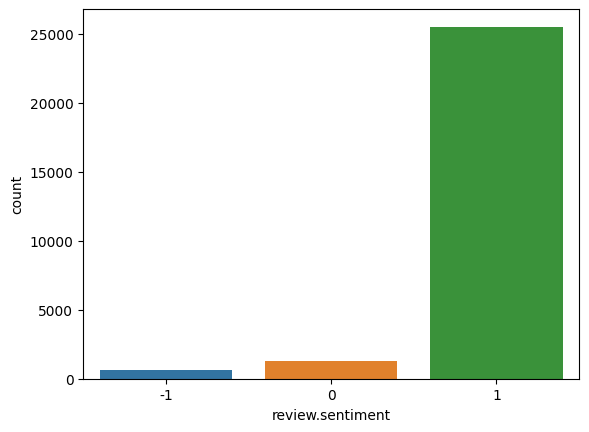

In [47]:
# plot sentiment counts for each product name or product category
sns.countplot(x=df['review.sentiment'])

In [89]:
df['asins'].nunique()

19

In [ ]:
df_catagories = df.groupby('asins')
df_catagories.first()

Text(0, 0.5, 'review sentiment')

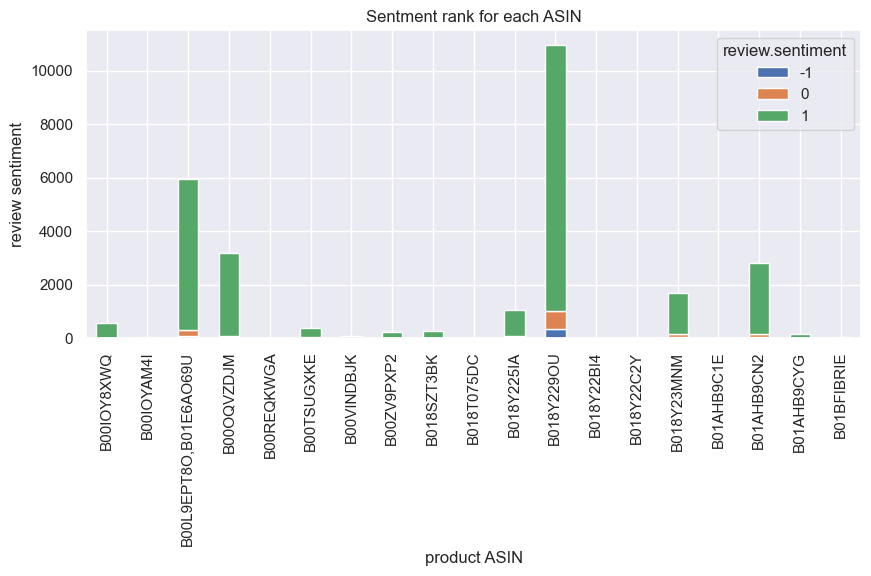

In [90]:
pd.crosstab(df['asins'],df['review.sentiment']).plot(kind="bar",stacked=True, figsize=(10, 4))
plt.title("Sentment rank for each ASIN")
plt.xlabel('product ASIN')
plt.ylabel('review sentiment')


  

In [93]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

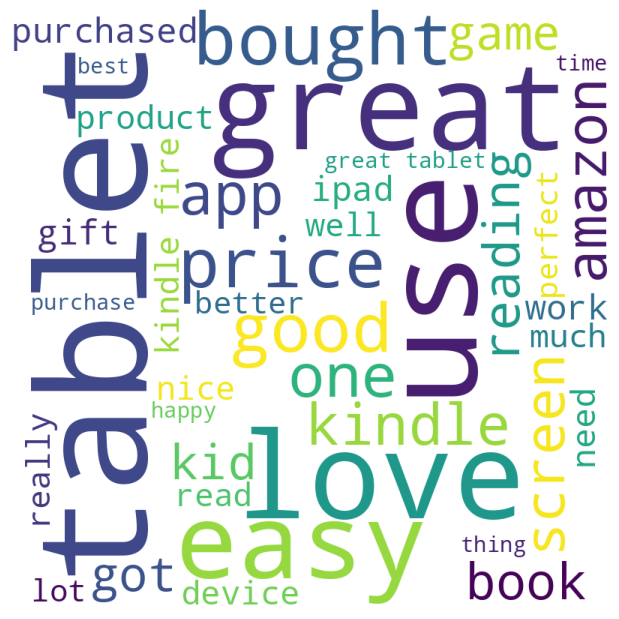

In [103]:
#word cloud: frequent word for each ASIN
list_asins = df['asins'].unique()

curr_asin = list_asins[0]
filtered_product = df[df['asins']==curr_asin]
concat_words = filtered_product['reviews.text'].str.cat(sep=' ')

tokens = concat_words.split()
comment_words=''
for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
    
comment_words += " ".join(tokens)+" "

# text(x=0.5, y=0.5, "Frequent word from review text for product with ASIN")

wordcloud = WordCloud(max_words=40, width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words)

          
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()


Building machine learning model

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
#preparing training and test dataset

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Vectorizer initialization
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

X_train = tfidf_vectorizer.fit_transform(train_df['reviews.text'])
X_test = tfidf_vectorizer.transform(test_df['reviews.text'])

y_train = train_df['review.sentiment']
y_test = test_df['review.sentiment']

In [34]:
# Using Logistic Regression model
lr_classifier = LogisticRegression(max_iter=10)
lr_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9240827000081719

Classification Report:
              precision    recall  f1-score   support

          -1       0.61      0.28      0.38       464
           0       0.14      0.01      0.01       527
           1       0.93      0.99      0.96     11246

    accuracy                           0.92     12237
   macro avg       0.56      0.43      0.45     12237
weighted avg       0.89      0.92      0.90     12237



c:\BeCode\CustomerReviewAnalysis\venv\venv_reviewanalysis\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Using Logistic Regression model
lr_classifier = LogisticRegression(max_iter=10)
lr_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))